# CNN Model on Chest X-ray Dataset
Building a CNN model on chest x-ray dataset. We use a smaller sample of the dataset

Add more data to get a better result

[Dataset on kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

## Contents
* Data Augmentation
* Imbalanced Data Handling
* Modeling
* Model Improving
* Evaluation

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
sns.set(font_scale=1.3)

### Data Augmentation
The data is huge, so we don't load the data directly

In [82]:
image_generator = ImageDataGenerator(shear_range=0.2,         
                                     zoom_range=0.2,         
                                     rescale=1./255.)

image_generator_test = ImageDataGenerator(rescale=1./255.)

In [83]:
train_data = image_generator.flow_from_directory(
    directory='data',
    target_size=(500, 500),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=30
)

Found 550 images belonging to 2 classes.


In [84]:
test_data = image_generator_test.flow_from_directory(
    directory='test_data',
    target_size=(500, 500),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=30
)

Found 74 images belonging to 2 classes.


Data is imbalanced

In [85]:
print(len(train_data.classes[train_data.classes == 0]) / train_data.samples * 100, '%', 'Data belongs to class 0')
print(len(train_data.classes[train_data.classes == 1]) / train_data.samples * 100, '%', 'Data belongs to class 1')

35.81818181818181 % Data belongs to class 0
64.18181818181819 % Data belongs to class 1


### Imbalanced Data Handling
Here we use class weights to handle imbalanced data

In [86]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights = dict(zip(np.unique(train_data.classes), weights))
class_weights

{0: 1.3959390862944163, 1: 0.7790368271954674}

So we have 1.39 for class 0 and 0.77 for class 1

### Modeling
4 convolution blocks. Each block has convolution layer, batch normalization layer, max pooling layer and dropout layer.

2 hidden dense layers followed by dropout layers and one neuron for the last layer

In [87]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [88]:
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 500, 500, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 500, 500, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 250, 250, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 250, 250, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 250, 32)      9248      
                                                                 
 batch_normalization_5 (Batc  (None, 250, 250, 32)    

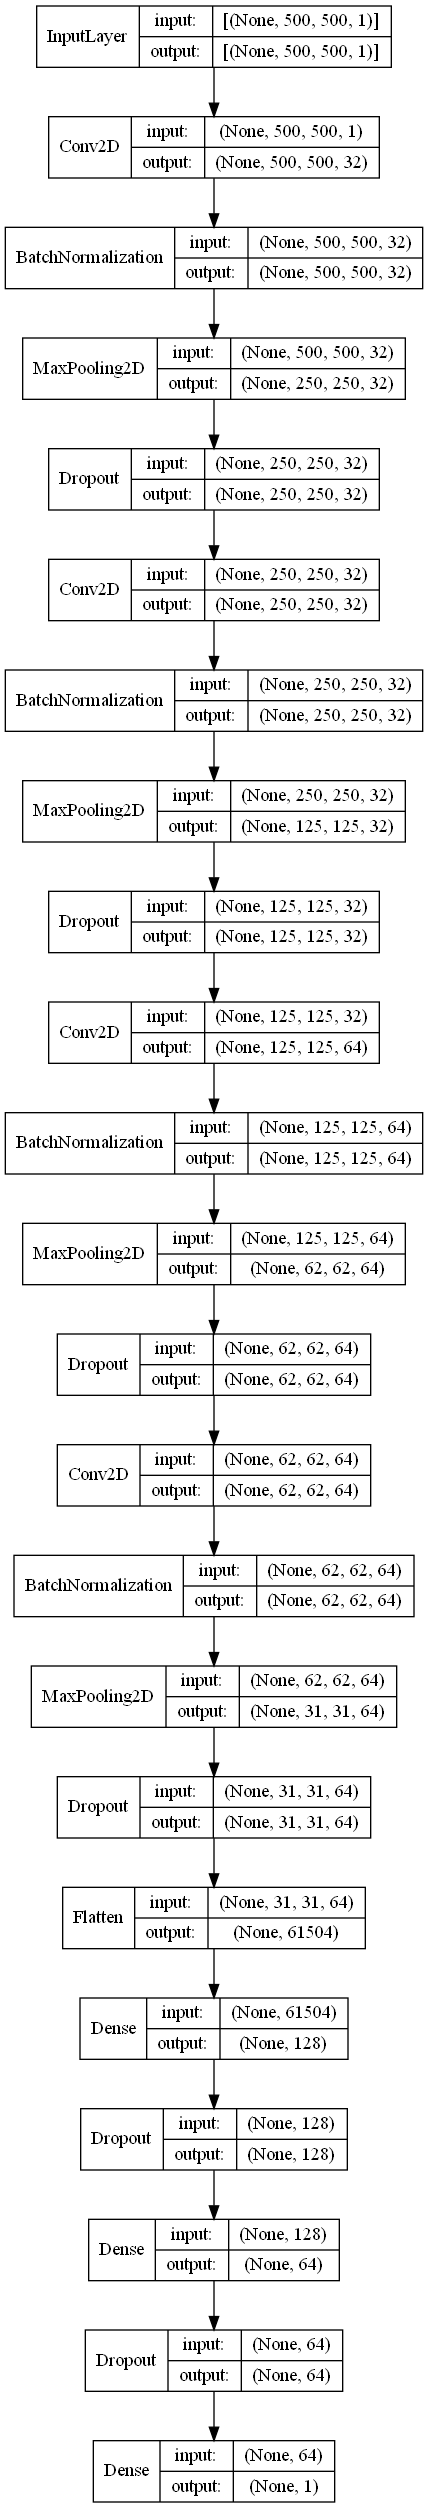

In [57]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Model Improving
* Early stopping
* ReduceLROnPlateau

In [58]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=0.001)

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=test_data, class_weight=class_weights, callbacks=[es, reduce])

Epoch 1/10
19/19 [==============================] - 215s 11s/step - loss: 1.0941 - accuracy: 0.6309 - val_loss: 0.7305 - val_accuracy: 0.5000
Epoch 2/10
19/19 [==============================] - 207s 11s/step - loss: 0.6570 - accuracy: 0.7273 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/10
19/19 [==============================] - 192s 10s/step - loss: 0.4804 - accuracy: 0.7782 - val_loss: 0.6852 - val_accuracy: 0.5000
Epoch 4/10
19/19 [==============================] - 194s 10s/step - loss: 0.3781 - accuracy: 0.8473 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 5/10
19/19 [==============================] - 188s 10s/step - loss: 0.3441 - accuracy: 0.8545 - val_loss: 0.8787 - val_accuracy: 0.5000
Epoch 6/10
19/19 [==============================] - 190s 10s/step - loss: 0.3313 - accuracy: 0.8473 - val_loss: 0.9316 - val_accuracy: 0.5000
Epoch 7/10
14/19 [=====================>........] - ETA: 51s - loss: 0.3694 - accuracy: 0.8333 

### Evaluation

In [ ]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')
plt.title('Loss Function')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], color='green', label='Train Data')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Data')
plt.title('Accuracy Function')
plt.legend()
plt.show()